<a href="https://colab.research.google.com/github/Junia-HugoCorne/Projet-NLP/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score, accuracy_score
import seaborn as sns

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :
https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [3]:
# Chargement des données
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')

# Affichage des premières lignes
print("Aperçu des données :")
print(df.head())

Mounted at /content/drive
Aperçu des données :
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


# Etude du jeu de données

In [4]:
# Informations sur le jeu de données
print("\nInformations sur le jeu de données:")
print(f"Nombre d'échantillons: {df.shape[0]}")
print(f"Nombre de colonnes: {df.shape[1]}")

# Vérification des colonnes de classification (pour éviter l'erreur de dimensions)
print("\nColonnes de classification:")
target_columns = df.columns[2:]
print(target_columns)
print(f"Nombre de classes: {len(target_columns)}")

# Distribution des classes
print("\nDistribution des classes:")
for column in target_columns:
    positive_samples = df[column].sum()
    percentage = positive_samples / len(df) * 100
    print(f"{column}: {positive_samples} commentaires ({percentage:.2f}%)")



Informations sur le jeu de données:
Nombre d'échantillons: 159571
Nombre de colonnes: 8

Colonnes de classification:
Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
Nombre de classes: 6

Distribution des classes:
toxic: 15294 commentaires (9.58%)
severe_toxic: 1595 commentaires (1.00%)
obscene: 8449 commentaires (5.29%)
threat: 478 commentaires (0.30%)
insult: 7877 commentaires (4.94%)
identity_hate: 1405 commentaires (0.88%)


# Prétraitement du texte

In [5]:
# Extraction des features et des labels
x = df.comment_text
y = df[target_columns].values

# Configuration du vectoriseur de texte
max_words = 200000
sequence_length = 2000

# Création et adaptation du vectoriseur
vectorizer = TextVectorization(
    max_tokens=max_words,
    output_sequence_length=sequence_length,
    output_mode='int'
)
vectorizer.adapt(x.values)

# Vérification du vocabulaire
print(f"\nTaille du vocabulaire: {len(vectorizer.get_vocabulary())}")

# Vectorisation du texte
vectorized_text = vectorizer(x.values)

# Test de vectorisation
test_text = "Hello world, life is great"
test_vec = vectorizer(test_text)
print(f"\nTest de vectorisation: '{test_text}' -> {test_vec[:10]}...")


Taille du vocabulaire: 200000

Test de vectorisation: 'Hello world, life is great' -> [288 263 306   9 275   0   0   0   0   0]...


# Création des datasets d'entraînement, validation et test

In [6]:
# Création d'un dataset TensorFlow
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

# Vérification des dimensions d'un batch
batch_x, batch_y = dataset.as_numpy_iterator().next()
print("\nDimensions d'un batch:")
print(f"X shape: {batch_x.shape}")
print(f"Y shape: {batch_y.shape}")

# Division en ensembles d'entraînement, validation et test
total_batches = len(list(dataset))
print(f"Nombre total de batches: {total_batches}")

train = dataset.take(int(total_batches * 0.7))
val = dataset.skip(int(total_batches * 0.7)).take(int(total_batches * 0.2))
test = dataset.skip(int(total_batches * 0.9)).take(int(total_batches * 0.1))


Dimensions d'un batch:
X shape: (16, 2000)
Y shape: (16, 6)
Nombre total de batches: 9974


# Construction et entraînement du modèle

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 793s 113ms/step - accuracy: 0.9538 - loss: 0.0832 - val_accuracy: 0.9940 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 842s 121ms/step - accuracy: 0.9916 - loss: 0.0461 - val_accuracy: 0.9944 - val_loss: 0.0404 - learning_rate: 0.0010
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 858s 123ms/step - accuracy: 0.9876 - loss: 0.0401 - val_accuracy: 0.9941 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 813s 116ms/step - accuracy: 0.9896 - loss: 0.0365 - val_accuracy: 0.9940 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 812s 116ms/step - accuracy: 0.9937 - loss: 0.0319 - val_accuracy: 0.9943 - val_loss: 0.0285 - learning_rate: 0.0010


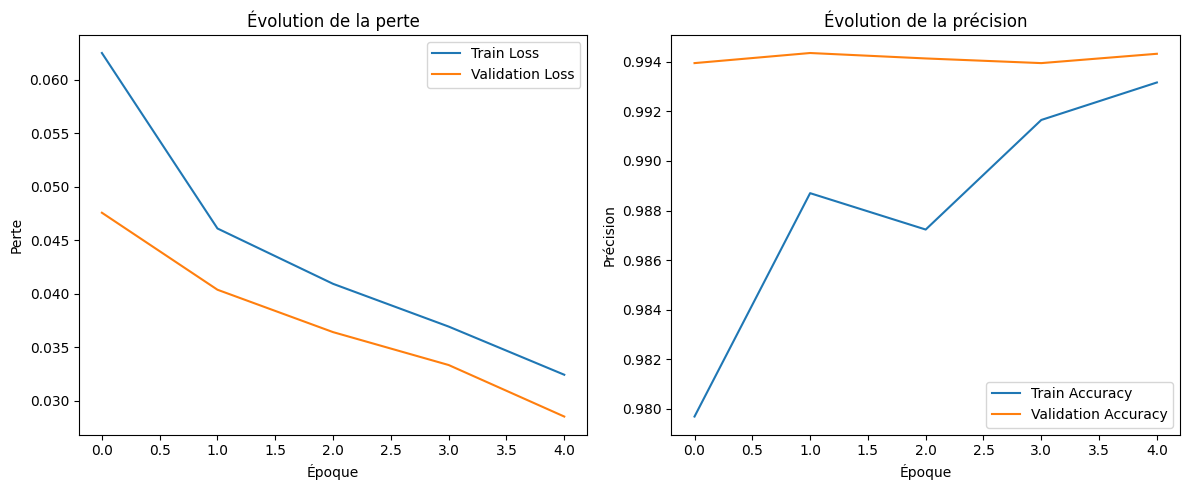

In [8]:
# Création du modèle
model = Sequential([
    Embedding(max_words + 1, 32),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(target_columns), activation='sigmoid')  # Nombre dynamique basé sur les colonnes cibles
])

# Affichage du résumé du modèle
model.summary()

# Compilation du modèle
model.compile(
    loss='BinaryCrossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

# Callbacks pour améliorer l'entraînement
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

# Entraînement du modèle
history = model.fit(
    train,
    epochs=5,
    validation_data=val,
    callbacks=[early_stopping, reduce_lr]
)

# Visualisation de l'historique d'entraînement
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Évolution de la perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Évolution de la précision')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

# Évaluation du modèle

In [9]:
# Initialisation des métriques
precision = Precision()
recall = Recall()

# Collecte des prédictions et des vraies valeurs
all_y_true = []
all_y_pred = []

for batch_x, batch_y in test:
    # Prédictions
    y_pred = model.predict(batch_x)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Stockage pour l'analyse
    all_y_true.extend(batch_y.numpy())
    all_y_pred.extend(y_pred_binary)

    # Mise à jour des métriques globales
    precision.update_state(batch_y.numpy().flatten(), y_pred.flatten())
    recall.update_state(batch_y.numpy().flatten(), y_pred.flatten())

# Conversion en arrays numpy
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)

# Calcul des métriques globales
precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
f1_value = (2 * precision_value * recall_value) / (precision_value + recall_value)
accuracy_value = accuracy_score(all_y_true.flatten(), all_y_pred.flatten())

print("\nPerformances globales du modèle:")
print(f"Précision (Precision): {precision_value:.4f}")
print(f"Rappel (Recall): {recall_value:.4f}")
print(f"F1-Score: {f1_value:.4f}")
print(f"Exactitude (Accuracy): {accuracy_value:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━

# Analyse des performances par classe


Performances par classe:
               precision    recall  f1-score   support

        toxic       0.88      0.94      0.91      1534
 severe_toxic       0.64      0.57      0.60       146
      obscene       0.94      0.87      0.90       844
       threat       0.00      0.00      0.00        53
       insult       0.82      0.81      0.81       763
identity_hate       0.63      0.26      0.37       139

    micro avg       0.87      0.84      0.85      3479
    macro avg       0.65      0.57      0.60      3479
 weighted avg       0.85      0.84      0.84      3479
  samples avg       0.09      0.08      0.08      3479

toxic: F1-Score = 0.9073
severe_toxic: F1-Score = 0.6014
obscene: F1-Score = 0.9031
threat: F1-Score = 0.0000
insult: F1-Score = 0.8124
identity_hate: F1-Score = 0.3673


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

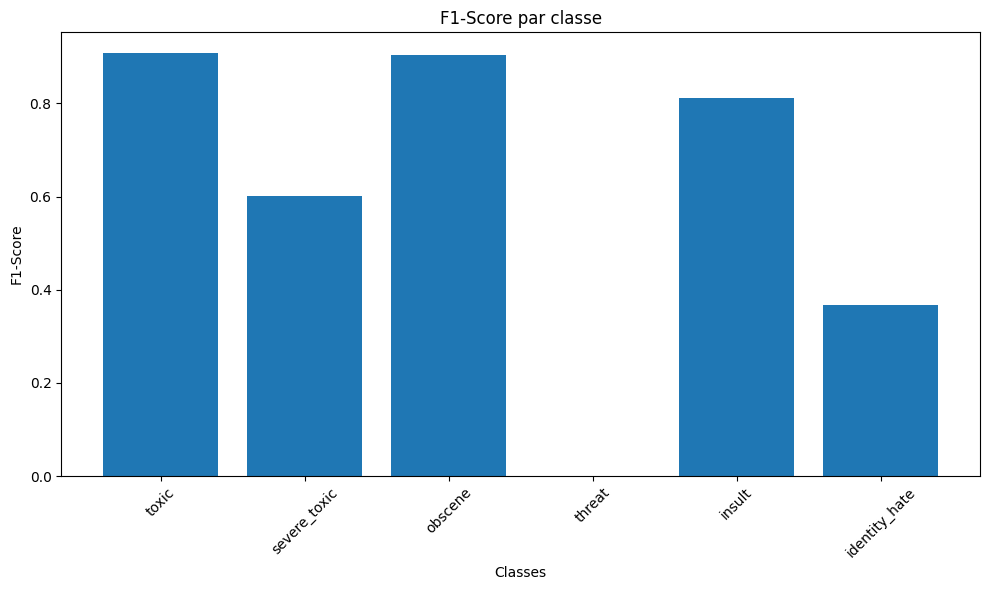

In [10]:
# Analyse des performances par classe
print("\nPerformances par classe:")
class_report = classification_report(
    all_y_true,
    all_y_pred,
    target_names=target_columns,
    output_dict=True
)

# Affichage du rapport de classification
print(classification_report(all_y_true, all_y_pred, target_names=target_columns))

# Calcul du F1-Score pour chaque classe
f1_scores = {}
for i, class_name in enumerate(target_columns):
    f1 = f1_score(all_y_true[:, i], all_y_pred[:, i])
    f1_scores[class_name] = f1
    print(f"{class_name}: F1-Score = {f1:.4f}")

# Visualisation des F1-Scores par classe
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title('F1-Score par classe')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()